In [2]:
#For downloads
import gdown, os, gzip, shutil

# Basic data management and plotting
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import os
from scipy.stats import median_abs_deviation

# Scanpy fundamentals
import anndata as ad
import scanpy as sc
import seaborn as sb

# sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(figsize=(6, 6))
import scvi
from scvi.model import SCVI
from scvi.external import SOLO

# Integration & Batch effect remove

Single-cell experiments are often conducted in multiple batches or across different platforms, leading to technical variability. When combining datasets, these batch effects can introduce noise, making it challenging to identify true biological differences. Data integration aims to correct for these batch effects, allowing researchers to work with a unified, consistent dataset.

Data integration aligns multiple single-cell datasets, removing technical differences and allowing meaningful comparisons between them. This step is crucial when you want to analyze combined data, such as pooling samples from different experiments or merging data from different research groups which is the case of this analysis.

To remove these technical artifacts after integration, we employed **scVI (Single-cell Variational Inference)** which is a deep learning-based approach to data integration in single-cell analysis. It uses a variational autoencoder (VAE), a type of neural network, to create a low-dimensional representation of single-cell data. scVI's strength lies in its ability to model complex relationships in the data, making it particularly useful for integrating datasets with diverse batch structures or high heterogeneity.

### How it works

The model is trained on the combined dataset to learn its underlying structure, allowing it to map the high-dimensional data into a lower-dimensional "latent space." This latent space representation process key biological patterns while reducing technical noise, providing a common ground for integrating multiple datasets. During training, scVI identifies and corrects batch effects by distinguishing between biological and technical variability, ensuring that differences observed in the data reflect true biological variation. After integration, this latent space representation can be used for downstream analyses, including clustering, visualization with techniques like UMAP or t-SNE, and differential gene expression analysis. The integrated dataset from scVI offers a cohesive view of single-cell data, enabling meaningful insights into the biological complexity of the samples.

This process, after quality control and normalization were done, it took 5 to 6 hours for the scvi algorithm to completely integrate the 12 samples and correct the batch effect. 

In [2]:
def pp(h5ad_path):
    adata = sc.read_h5ad(h5ad_path) 
    sc.pp.filter_genes(adata, min_cells=10)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft=False)
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    df = df.dropna()
    adata = sc.read_h5ad(h5ad_path)
    adata.obs['Sample'] = h5ad_path.split('_')[2]  
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    sc.pp.filter_cells(adata, min_genes=200)
    adata.var['mt'] = adata.var_names.str.startswith('mt-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=[20], log1p=True, inplace=True)
    
    # Función para detectar outliers
    def is_outlier(adata, metric: str, nmads: int):
        M = adata.obs[metric]
        outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
            np.median(M) + nmads * median_abs_deviation(M) < M
        )
        return outlier

    # Detectar outliers en las métricas de calidad
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 5)
        | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )
    adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
        adata.obs["pct_counts_mt"] > 25
    )
    
    # Filtrar outliers
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    
    df = df.dropna()  
    return adata


In [3]:
os.listdir('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/initial_h5ad')

['control_2',
 'control_5',
 'tumor_4',
 'control_1',
 'control_6',
 'tumor_3',
 'tumor_1',
 'control_4',
 'control_3',
 'tumor_2',
 'control_7',
 'tumor_5']

In [8]:
import os

# Ruta al directorio donde se encuentra el archivo .ipynb_checkpoints
directory = '/datos/home/jupyter-mdiaz/scRNAseq_pipeline/initial_h5ad/'

# Nombre del archivo o directorio a eliminar
file_to_remove = '.ipynb_checkpoints'

# Crear la ruta completa al archivo o directorio
full_path = os.path.join(directory, file_to_remove)

# Verificar si existe y eliminarlo
if os.path.exists(full_path):
    if os.path.isdir(full_path):
        os.rmdir(full_path)  # Elimina el directorio si está vacío
    else:
        os.remove(full_path)  # Elimina el archivo
    print(f"{file_to_remove} ha sido eliminado exitosamente.")
else:
    print(f"{file_to_remove} no existe en el directorio especificado.")


.ipynb_checkpoints ha sido eliminado exitosamente.


In [4]:
out = []
for file in os.listdir('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/initial_h5ad/'):
    out.append(pp('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/initial_h5ad/' + file))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [05:01<00:00,  1.32it/s, v_num=1, train_loss_step=409, train_loss_epoch=355]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:01<00:00,  1.33it/s, v_num=1, train_loss_step=409, train_loss_epoch=355]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 219/400:  55%|█████▍    | 219/400 [02:11<01:48,  1.67it/s, v_num=1, train_loss_step=0.307, train_loss_epoch=0.342]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.329. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

Epoch 400/400: 100%|██████████| 400/400 [05:17<00:00,  1.19it/s, v_num=1, train_loss_step=283, train_loss_epoch=267]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:17<00:00,  1.26it/s, v_num=1, train_loss_step=283, train_loss_epoch=267]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 231/400:  58%|█████▊    | 231/400 [01:50<01:20,  2.09it/s, v_num=1, train_loss_step=0.305, train_loss_epoch=0.238]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.221. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

Epoch 400/400: 100%|██████████| 400/400 [06:34<00:00,  1.01it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.07e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:34<00:00,  1.01it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.07e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 121/400:  30%|███       | 121/400 [01:22<03:09,  1.47it/s, v_num=1, train_loss_step=0.256, train_loss_epoch=0.243] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.238. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

Epoch 400/400: 100%|██████████| 400/400 [03:25<00:00,  3.76it/s, v_num=1, train_loss_step=320, train_loss_epoch=319]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:25<00:00,  1.95it/s, v_num=1, train_loss_step=320, train_loss_epoch=319]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 219/400:  55%|█████▍    | 219/400 [00:57<00:47,  3.78it/s, v_num=1, train_loss_step=0.369, train_loss_epoch=0.288]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.265. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

Epoch 400/400: 100%|██████████| 400/400 [08:41<00:00,  1.31s/it, v_num=1, train_loss_step=654, train_loss_epoch=589]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [08:41<00:00,  1.30s/it, v_num=1, train_loss_step=654, train_loss_epoch=589]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 187/400:  47%|████▋     | 187/400 [02:57<03:22,  1.05it/s, v_num=1, train_loss_step=0.334, train_loss_epoch=0.352]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.342. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

Epoch 400/400: 100%|██████████| 400/400 [10:46<00:00,  1.62s/it, v_num=1, train_loss_step=796, train_loss_epoch=802]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [10:46<00:00,  1.62s/it, v_num=1, train_loss_step=796, train_loss_epoch=802]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 170/400:  42%|████▎     | 170/400 [02:55<03:57,  1.03s/it, v_num=1, train_loss_step=0.362, train_loss_epoch=0.28] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.265. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

Epoch 400/400: 100%|██████████| 400/400 [06:26<00:00,  1.04it/s, v_num=1, train_loss_step=953, train_loss_epoch=964]      

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:26<00:00,  1.03it/s, v_num=1, train_loss_step=953, train_loss_epoch=964]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 101/400:  25%|██▌       | 101/400 [01:08<03:22,  1.48it/s, v_num=1, train_loss_step=0.321, train_loss_epoch=0.225]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.217. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

Epoch 400/400: 100%|██████████| 400/400 [02:13<00:00,  2.97it/s, v_num=1, train_loss_step=385, train_loss_epoch=393]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:13<00:00,  2.99it/s, v_num=1, train_loss_step=385, train_loss_epoch=393]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [01:48<00:00,  3.67it/s, v_num=1, train_loss_step=0.235, train_loss_epoch=0.259]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:48<00:00,  3.70it/s, v_num=1, train_loss_step=0.235, train_loss_epoch=0.259]


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("v

Epoch 400/400: 100%|██████████| 400/400 [02:02<00:00,  3.27it/s, v_num=1, train_loss_step=407, train_loss_epoch=359]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:02<00:00,  3.27it/s, v_num=1, train_loss_step=407, train_loss_epoch=359]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 395/400:  99%|█████████▉| 395/400 [01:36<00:01,  4.08it/s, v_num=1, train_loss_step=0.457, train_loss_epoch=0.357]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.338. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

Epoch 400/400: 100%|██████████| 400/400 [18:55<00:00,  2.84s/it, v_num=1, train_loss_step=792, train_loss_epoch=770]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [18:55<00:00,  2.84s/it, v_num=1, train_loss_step=792, train_loss_epoch=770]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 191/400:  48%|████▊     | 191/400 [04:40<05:06,  1.47s/it, v_num=1, train_loss_step=0.213, train_loss_epoch=0.296]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.279. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

Epoch 400/400: 100%|██████████| 400/400 [07:14<00:00,  1.08s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.14e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [07:14<00:00,  1.09s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.14e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 286/400:  72%|███████▏  | 286/400 [03:15<01:17,  1.46it/s, v_num=1, train_loss_step=0.363, train_loss_epoch=0.268] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.256. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

Epoch 400/400: 100%|██████████| 400/400 [10:46<00:00,  1.59s/it, v_num=1, train_loss_step=837, train_loss_epoch=801]    

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [10:46<00:00,  1.62s/it, v_num=1, train_loss_step=837, train_loss_epoch=801]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 243/400:  61%|██████    | 243/400 [04:06<02:39,  1.01s/it, v_num=1, train_loss_step=0.173, train_loss_epoch=0.273]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.268. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

In [5]:
# Remove duplicate labels
for ad in out:
    ad.obs_names_make_unique()
    ad.var_names_make_unique()

# Concatenate Anndata object
adata = sc.concat(out)

# Make sure index and labels are unique
adata.obs_names_make_unique()
adata.var_names_make_unique()


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
adata

AnnData object with n_obs × n_vars = 105717 × 11762
    obs: 'n_genes', 'Sample', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'

In [7]:
sc.pp.filter_genes(adata, min_cells = 10)

In [8]:
adata.X

<105717x11762 sparse matrix of type '<class 'numpy.float32'>'
	with 195714185 stored elements in Compressed Sparse Row format>

In [9]:
from scipy.sparse import csr_matrix

In [10]:
adata.X = csr_matrix(adata.X)
adata.X

<105717x11762 sparse matrix of type '<class 'numpy.float32'>'
	with 195714185 stored elements in Compressed Sparse Row format>

In [11]:
adata

AnnData object with n_obs × n_vars = 105717 × 11762
    obs: 'n_genes', 'Sample', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'n_cells'

In [12]:
adata.obs['Sample']


ACAGCTAGTCGCGTGT        h5ad/control
TGAAAGATCTGCAAGT        h5ad/control
GGTGTTATCAGAGCTT        h5ad/control
GCCAAATCAAAGCAAT        h5ad/control
GTCACGGCAGATCGGA        h5ad/control
                            ...     
TTTGTTGGTGCTTATG-1-1      h5ad/tumor
TTTGTTGGTGGACTGA-1-1      h5ad/tumor
TTTGTTGGTTCATCTT-1-1      h5ad/tumor
TTTGTTGGTTTCAGAC-1-1      h5ad/tumor
TTTGTTGTCTCTAGGA-1-1      h5ad/tumor
Name: Sample, Length: 105717, dtype: object

In [13]:
sc.pp.filter_genes(adata, min_cells = 100)

In [14]:
adata.layers['counts'] = adata.X.copy()

In [15]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [ ]:
adata.write_h5ad('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/adata_saved/probe_Unintegrated_2024b.h5ad')

# Integration with scVI

If you have already trained a model, load the saved model. **{**

**model_dir = '/datos/home/jupyter-mdiaz/scRNAseq_pipeline/model_2024/saved_model'**

**model = SCVI.load(model_dir)**

**}**

In [5]:
adata = sc.read_h5ad('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/adata_saved/probe_integrated_2024b.h5ad')

In [6]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts'])

In [7]:
model=scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood='nb')

In [8]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 76/76: 100%|██████████| 76/76 [23:14<00:00, 18.30s/it, v_num=1, train_loss_step=4.98e+3, train_loss_epoch=5.17e+3]

`Trainer.fit` stopped: `max_epochs=76` reached.


Epoch 76/76: 100%|██████████| 76/76 [23:14<00:00, 18.34s/it, v_num=1, train_loss_step=4.98e+3, train_loss_epoch=5.17e+3]


In [ ]:
## Save scVI model
#save_dir = '/datos/home/jupyter-mdiaz/scRNAseq_pipeline/adata_saved/'

#model_dir = os.path.join(save_dir, "saved_model")

#model.save(model_dir, save_anndata=True)

In [3]:
# To load you model

#model_dir = '/datos/home/jupyter-mdiaz/scRNAseq_pipeline/model_2024/saved_model'

#model = SCVI.load(model_dir)

INFO     File /datos/home/jupyter-mdiaz/scRNAseq_pipeline/model_2024/saved_model/model.pt already downloaded       


In [12]:
adata

AnnData object with n_obs × n_vars = 105717 × 11762
    obs: 'n_genes', 'Sample', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'log1p', 'neighbors'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [13]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [14]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)

In [15]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              
Aug 09 06:19:43 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Aug 09 06:19:43 PM: The following items have duplicates [ 39681  39683  39685 ... 105592 105593 105595]


In [16]:
adata.layers['scvi_normalized']=model.get_normalized_expression(library_size = 1e4)

/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:401: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


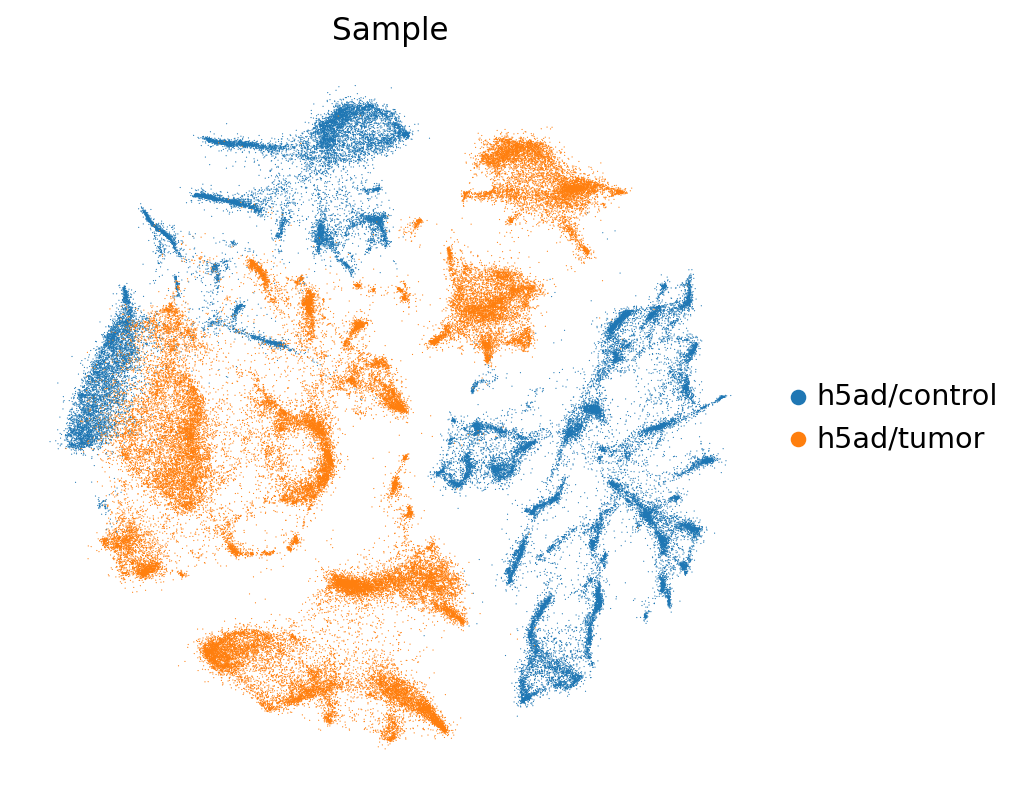

In [20]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["Sample"],
    frameon=False,
    ncols=1,
)

In [18]:
adata.obs

,n_genes,Sample,doublet,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,outlier,mt_outlier,_scvi_batch,_scvi_labels,leiden
ACAGCTAGTCGCGTGT,465,h5ad/control,False,465,6.144186,2141.0,7.669495,69.266698,0.0,0.0,0.0,False,False,0,0,9
TGAAAGATCTGCAAGT,1882,h5ad/control,False,1882,7.540622,7940.0,8.979795,34.445844,0.0,0.0,0.0,False,False,0,0,9
GGTGTTATCAGAGCTT,501,h5ad/control,False,501,6.218600,1319.0,7.185387,39.044731,0.0,0.0,0.0,False,False,0,0,7
GCCAAATCAAAGCAAT,1877,h5ad/control,False,1877,7.537963,7853.0,8.968779,33.592258,0.0,0.0,0.0,False,False,0,0,9
GTCACGGCAGATCGGA,2033,h5ad/control,False,2033,7.617760,12843.0,9.460632,45.402165,0.0,0.0,0.0,False,False,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGCTTATG-1-1,2951,h5ad/tumor,False,2951,7.990238,5171.0,8.551015,12.608780,0.0,0.0,0.0,False,False,0,0,44
TTTGTTGGTGGACTGA-1-1,3425,h5ad/tumor,False,3425,8.139149,8629.0,9.063000,12.087148,0.0,0.0,0.0,False,False,0,0,41
TTTGTTGGTTCATCTT-1-1,1602,h5ad/tumor,False,1602,7.379632,2409.0,7.787382,11.290992,0.0,0.0,0.0,False,False,0,0,56
TTTGTTGGTTTCAGAC-1-1,2761,h5ad/tumor,False,2761,7.923710,5708.0,8.649799,13.384723,0.0,0.0,0.0,False,False,0,0,49


In [ ]:
#sc.pl.embedding(adata, basis=SCVI_MDE_KEY, color=["cell_type"], frameon=False, ncols=1)

In [40]:
adata.write_h5ad('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/adata_saved/probe_integrated_2024b.h5ad')

# Celltypist

## Creating celltypist models 

In [ ]:
#%pip install celltypist scvi-tools hyperopt "ray[tune]" anndata2ri

In [21]:
import celltypist
from celltypist import models

In [22]:
models.models_description()

👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_COVID19_PBMC.pkl,peripheral blood mononuclear cell types from C...
3,Adult_CynomolgusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult cynom...
4,Adult_Human_PancreaticIslet.pkl,cell types from pancreatic islets of healthy a...
5,Adult_Human_Skin.pkl,cell types from human healthy adult skin
6,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...
7,Adult_Mouse_OlfactoryBulb.pkl,cell types from the olfactory bulb of adult mice
8,Adult_Pig_Hippocampus.pkl,cell types from the adult pig hippocampus
9,Adult_RhesusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult rhesu...


In [23]:
model = models.Model.load('Healthy_Human_Liver.pkl')

In [24]:
model

CellTypist model with 17 cell types and 2691 features
    date: 2023-09-14 12:48:54.179790
    details: cell types from scRNA-seq and snRNA-seq of the adult human liver
    source: https://doi.org/10.1016/j.cell.2021.12.018
    version: v1
    cell types: B cells, Basophils, ..., pDCs
    features: HES4, TNFRSF18, ..., MT-CYB

In [25]:
model.cell_types

array(['B cells', 'Basophils', 'Cholangiocytes', 'Circulating NK/NKT',
       'Endothelial cells', 'Fibroblasts', 'Hepatocytes', 'Macrophages',
       'Mig.cDCs', 'Mono+mono derived cells', 'Neutrophils',
       'Plasma cells', 'Resident NK', 'T cells', 'cDC1s', 'cDC2s', 'pDCs'],
      dtype=object)

In [26]:
adata

AnnData object with n_obs × n_vars = 105717 × 11762
    obs: 'n_genes', 'Sample', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'log1p', 'neighbors'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [27]:
def predict_cells(adata):
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.normalize_total(adata, target_sum=1e4) #not recommended for typical pp
    sc.pp.log1p(adata)

    adata.X = adata.X.toarray()
    predictions = celltypist.annotate(adata, model = 'Healthy_Human_Liver.pkl', 
                                  majority_voting = True)
    adata = predictions.to_adata()
    adata.obs["predicted_label"] = adata.obs.loc[adata.obs.index, "predicted_labels"]
    adata.obs["over_clustering"] = adata.obs.loc[adata.obs.index, "over_clustering"]
    adata.obs["majority_voting"] = adata.obs.loc[adata.obs.index, "majority_voting"]

    return adata.obs

In [28]:
dataset = adata[:105717, :]
predictions = predict_cells(dataset.copy())
print(predictions)


🔬 Input data has 105717 cells and 11762 genes
🔗 Matching reference genes in the model
🧬 2027 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


                      n_genes        Sample  doublet  n_genes_by_counts  \
ACAGCTAGTCGCGTGT          465  h5ad/control    False                465   
TGAAAGATCTGCAAGT         1882  h5ad/control    False               1882   
GGTGTTATCAGAGCTT          501  h5ad/control    False                501   
GCCAAATCAAAGCAAT         1877  h5ad/control    False               1877   
GTCACGGCAGATCGGA         2033  h5ad/control    False               2033   
...                       ...           ...      ...                ...   
TTTGTTGGTGCTTATG-1-1     2951    h5ad/tumor    False               2951   
TTTGTTGGTGGACTGA-1-1     3425    h5ad/tumor    False               3425   
TTTGTTGGTTCATCTT-1-1     1602    h5ad/tumor    False               1602   
TTTGTTGGTTTCAGAC-1-1     2761    h5ad/tumor    False               2761   
TTTGTTGTCTCTAGGA-1-1     4239    h5ad/tumor    False               4239   

                      log1p_n_genes_by_counts  total_counts  \
ACAGCTAGTCGCGTGT                    

In [29]:
predictions = predictions[['predicted_label', 'over_clustering', 'majority_voting']]
predictions


,predicted_label,over_clustering,majority_voting
ACAGCTAGTCGCGTGT,Hepatocytes,48,Hepatocytes
TGAAAGATCTGCAAGT,Hepatocytes,206,Hepatocytes
GGTGTTATCAGAGCTT,Mono+mono derived cells,296,Mono+mono derived cells
GCCAAATCAAAGCAAT,Hepatocytes,106,Hepatocytes
GTCACGGCAGATCGGA,Hepatocytes,62,Hepatocytes
...,...,...,...
TTTGTTGGTGCTTATG-1-1,Hepatocytes,489,Hepatocytes
TTTGTTGGTGGACTGA-1-1,Hepatocytes,372,Hepatocytes
TTTGTTGGTTCATCTT-1-1,Macrophages,665,Macrophages
TTTGTTGGTTTCAGAC-1-1,Endothelial cells,322,Endothelial cells


In [30]:
adata

AnnData object with n_obs × n_vars = 105717 × 11762
    obs: 'n_genes', 'Sample', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'log1p', 'neighbors'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [31]:
# Crear DataFrames sin duplicados
obs_clean = adata.obs[~adata.obs.index.duplicated(keep='first')]
predictions_clean = predictions[~predictions.index.duplicated(keep='first')]

# Verificar nuevamente las longitudes después de eliminar duplicados
print(f"Longitud de obs_clean después de eliminar duplicados: {len(obs_clean)}")
print(f"Longitud de predictions_clean después de eliminar duplicados: {len(predictions_clean)}")

# Asegúrate de que ambos índices estén alineados
common_index = obs_clean.index.intersection(predictions_clean.index)
obs_clean = obs_clean.loc[common_index]
predictions_clean = predictions_clean.loc[common_index]

print(f"Índices comunes después de eliminar duplicados: {len(common_index)}")

# Realiza el merge
merged_obs = obs_clean.merge(right=predictions_clean, left_index=True, right_index=True)

# Crear un DataFrame temporal con los índices alineados
temp_obs = pd.DataFrame(index=adata.obs.index)
temp_obs = temp_obs.join(merged_obs, how="left")

# Verificar el resultado
print(f"Longitud final de temp_obs: {len(temp_obs)}")

Longitud de obs_clean después de eliminar duplicados: 105717
Longitud de predictions_clean después de eliminar duplicados: 105717
Índices comunes después de eliminar duplicados: 105717
Longitud final de temp_obs: 105717


In [32]:
# Asignar el DataFrame temporal a adata.obs
adata.obs = temp_obs

# Verificar el resultado final
print(f"Longitud final de adata.obs: {len(adata.obs)}")

Longitud final de adata.obs: 105717


In [33]:
adata

AnnData object with n_obs × n_vars = 105717 × 11762
    obs: 'n_genes', 'Sample', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_label', 'over_clustering', 'majority_voting'
    var: 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'log1p', 'neighbors'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [34]:
for col in adata.obs.columns:
    adata.obs[col] = adata.obs[col].astype(str)


In [35]:
print(adata)


AnnData object with n_obs × n_vars = 105717 × 11762
    obs: 'n_genes', 'Sample', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_label', 'over_clustering', 'majority_voting'
    var: 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'log1p', 'neighbors'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'


In [36]:
adata.obs

,n_genes,Sample,doublet,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,outlier,mt_outlier,_scvi_batch,_scvi_labels,leiden,predicted_label,over_clustering,majority_voting
ACAGCTAGTCGCGTGT,465,h5ad/control,False,465,6.144185634125646,2141.0,7.669495,69.26669780476414,0.0,0.0,0.0,False,False,0,0,9,Hepatocytes,48,Hepatocytes
TGAAAGATCTGCAAGT,1882,h5ad/control,False,1882,7.5406215286571525,7940.0,8.9797945,34.44584382871537,0.0,0.0,0.0,False,False,0,0,9,Hepatocytes,206,Hepatocytes
GGTGTTATCAGAGCTT,501,h5ad/control,False,501,6.218600119691729,1319.0,7.185387,39.044730856709634,0.0,0.0,0.0,False,False,0,0,7,Mono+mono derived cells,296,Mono+mono derived cells
GCCAAATCAAAGCAAT,1877,h5ad/control,False,1877,7.537962659768208,7853.0,8.968779,33.59225773589711,0.0,0.0,0.0,False,False,0,0,9,Hepatocytes,106,Hepatocytes
GTCACGGCAGATCGGA,2033,h5ad/control,False,2033,7.617759576608505,12843.0,9.460632,45.40216460328584,0.0,0.0,0.0,False,False,0,0,9,Hepatocytes,62,Hepatocytes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGCTTATG-1-1,2951,h5ad/tumor,False,2951,7.990238185720363,5171.0,8.551015,12.608779733127054,0.0,0.0,0.0,False,False,0,0,44,Hepatocytes,489,Hepatocytes
TTTGTTGGTGGACTGA-1-1,3425,h5ad/tumor,False,3425,8.139148678884064,8629.0,9.063,12.087147989338277,0.0,0.0,0.0,False,False,0,0,41,Hepatocytes,372,Hepatocytes
TTTGTTGGTTCATCTT-1-1,1602,h5ad/tumor,False,1602,7.3796321526095525,2409.0,7.787382,11.29099211290992,0.0,0.0,0.0,False,False,0,0,56,Macrophages,665,Macrophages
TTTGTTGGTTTCAGAC-1-1,2761,h5ad/tumor,False,2761,7.923710333969237,5708.0,8.649799,13.384723195515067,0.0,0.0,0.0,False,False,0,0,49,Endothelial cells,322,Endothelial cells


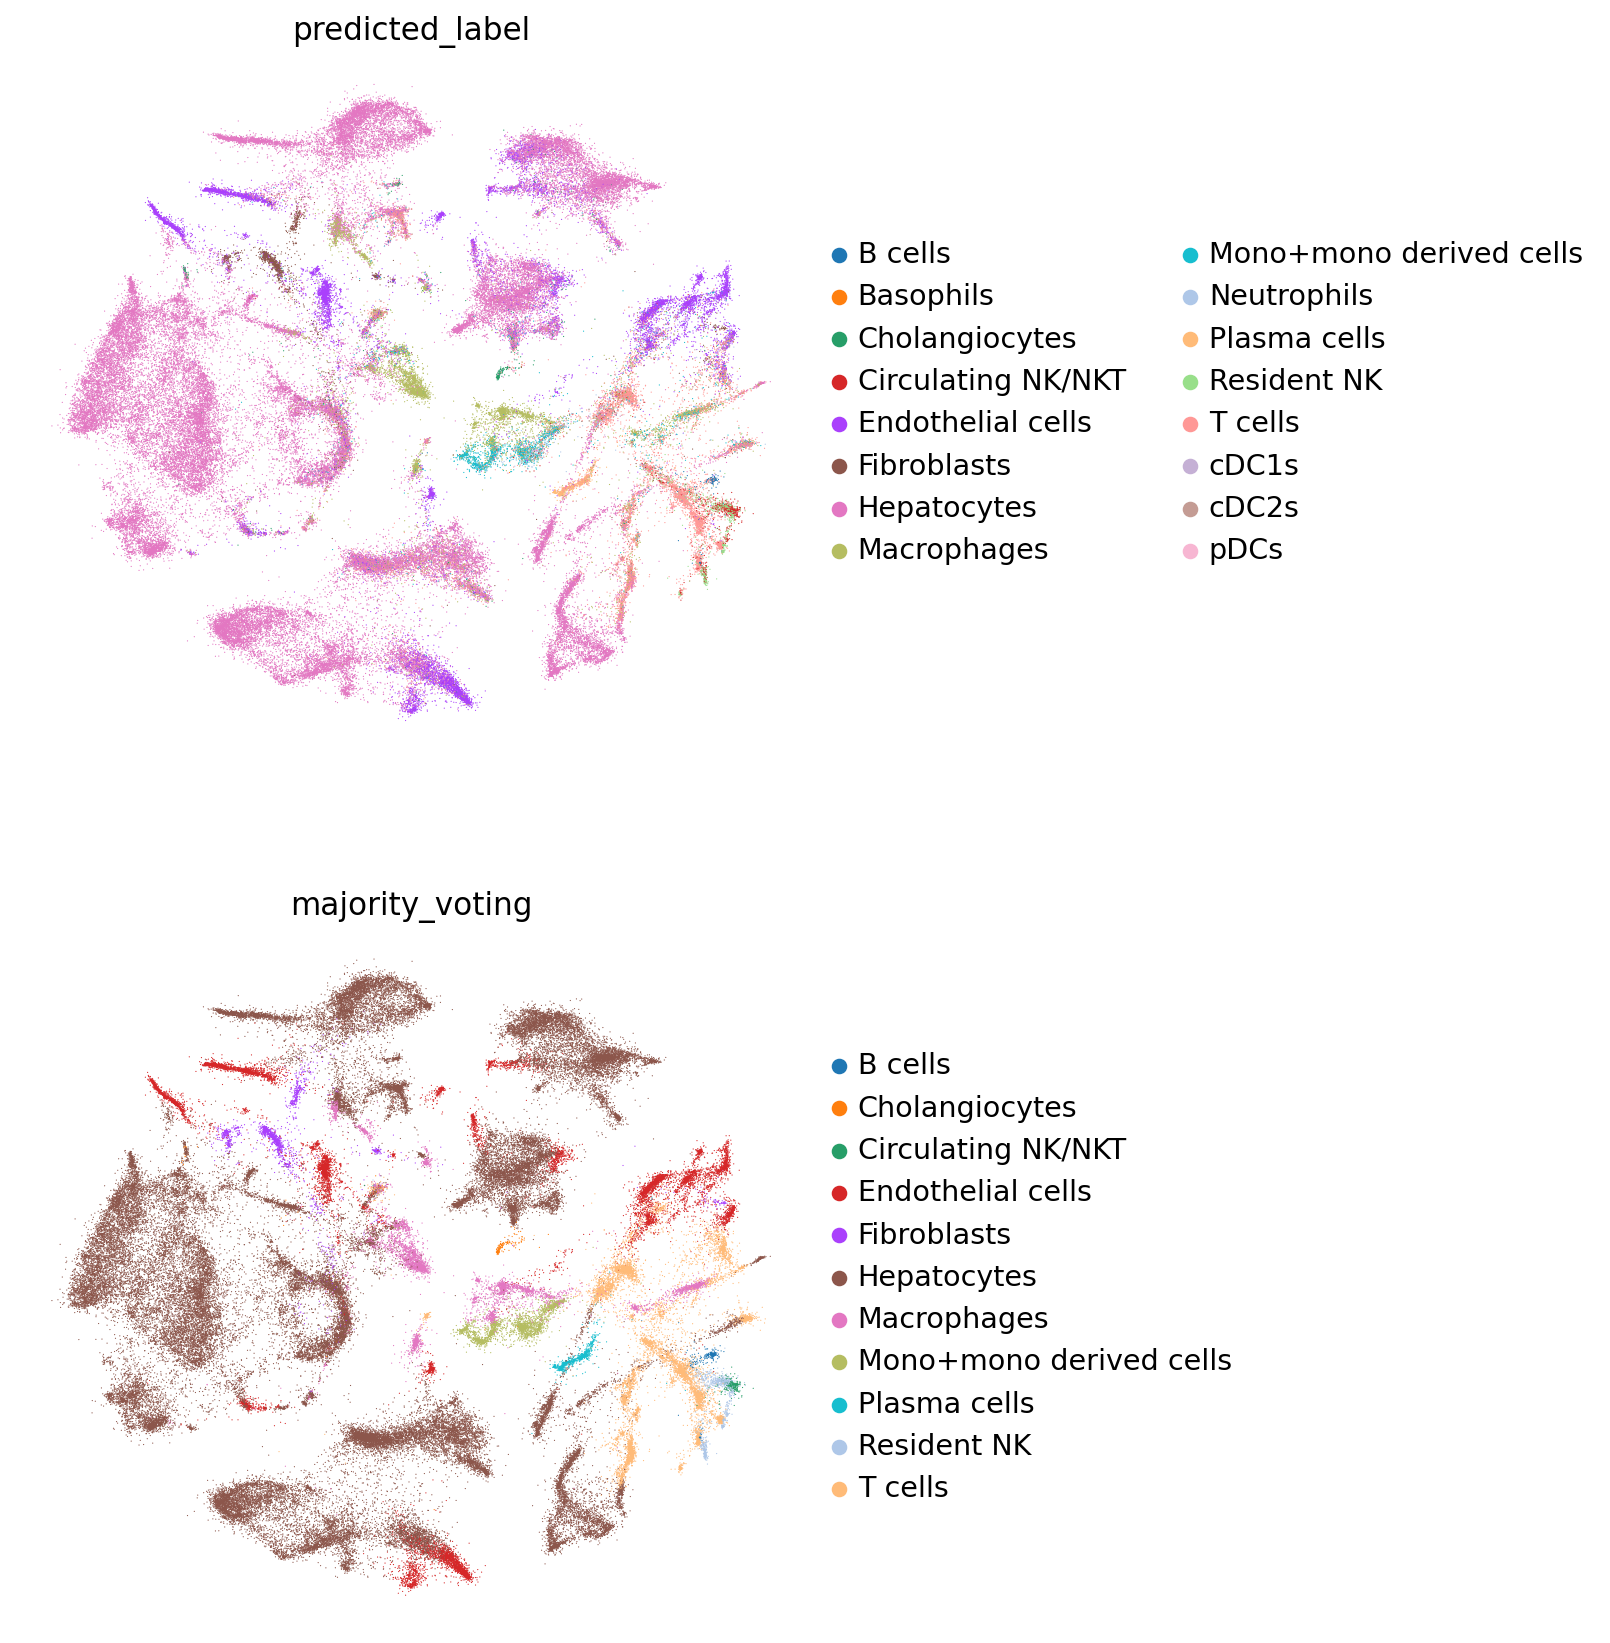

In [38]:
sc.pl.embedding(adata, basis=SCVI_MDE_KEY, color=["predicted_label", 'majority_voting'], frameon=False, ncols=1)


In [19]:
adata.write_h5ad('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/adata_saved/probe_annotatedCells_2024b.h5ad')

... storing 'n_genes' as categorical
... storing 'Sample' as categorical
... storing 'doublet' as categorical
... storing 'n_genes_by_counts' as categorical
... storing 'log1p_n_genes_by_counts' as categorical
... storing 'total_counts' as categorical
... storing 'log1p_total_counts' as categorical
... storing 'pct_counts_in_top_20_genes' as categorical
... storing 'total_counts_mt' as categorical
... storing 'log1p_total_counts_mt' as categorical
... storing 'pct_counts_mt' as categorical
... storing 'outlier' as categorical
... storing 'mt_outlier' as categorical
... storing '_scvi_batch' as categorical
... storing '_scvi_labels' as categorical
... storing 'leiden' as categorical
... storing 'predicted_label' as categorical
... storing 'over_clustering' as categorical
... storing 'majority_voting' as categorical
